In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
#from keras.utils import np_utils
#from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from keras.preprocessing.image import ImageDataGenerator


In [2]:

path = "Dataset"
labelFile = 'labels.csv'
batch_size_val=32
epochs_val=10
imageDimesions = (32,32,3)
testRatio = 0.2
validationRatio = 0.2

count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:",len(myList))
noOfClasses=len(myList)
print("Importing Classes.....")
for x in range (0,len(myList)):
    myPicList = os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count, end =" ")
    count +=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)



Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [3]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

In [4]:
print("Data Shapes")
print("Train",end = "");print(X_train.shape,y_train.shape)
print("Validation",end = "");print(X_validation.shape,y_validation.shape)
print("Test",end = "");print(X_test.shape,y_test.shape)

Data Shapes
Train(22265, 32, 32, 3) (22265,)
Validation(5567, 32, 32, 3) (5567,)
Test(6958, 32, 32, 3) (6958,)


In [5]:
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


In [6]:
num_of_samples = []
cols = 5
num_classes = noOfClasses

In [7]:
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [8]:
X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))


X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [9]:
dataGen= ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10)
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)
X_batch,y_batch = next(batches)


y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)

In [10]:
def myModel():
    model= Sequential()
    model.add((Conv2D(60,(5,5),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(60, (5,5), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add((Conv2D(30, (3,3),activation='relu')))
    model.add((Conv2D(30, (3,3), activation='relu')))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses,activation='softmax'))
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [11]:
model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=len(X_train)//32,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

c:\Users\devan\anaconda3\envs\TF\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\devan\AppData\Local\Temp\ipykernel_584\661097575.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),steps_per_epoch=len(X_train)//32,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)


695/695 [==============================] - 37s 51ms/step - loss: 2.3174 - accuracy: 0.3441 - val_loss: 0.7206 - val_accuracy: 0.7809
Epoch 2/10
695/695 [==============================] - 36s 52ms/step - loss: 1.1055 - accuracy: 0.6529 - val_loss: 0.3101 - val_accuracy: 0.9299
Epoch 3/10
695/695 [==============================] - 38s 54ms/step - loss: 0.7614 - accuracy: 0.7562 - val_loss: 0.1716 - val_accuracy: 0.9630
Epoch 4/10
695/695 [==============================] - 47s 68ms/step - loss: 0.5731 - accuracy: 0.8182 - val_loss: 0.1457 - val_accuracy: 0.9589
Epoch 5/10
695/695 [==============================] - 36s 52ms/step - loss: 0.4924 - accuracy: 0.8460 - val_loss: 0.0900 - val_accuracy: 0.9732
Epoch 6/10
695/695 [==============================] - 35s 50ms/step - loss: 0.4104 - accuracy: 0.8700 - val_loss: 0.0783 - val_accuracy: 0.9793
Epoch 7/10
695/695 [==============================] - 34s 50ms/step - loss: 0.3630 - accuracy: 0.8876 - val_loss: 0.0770 - val_accuracy: 0.9768
Epo

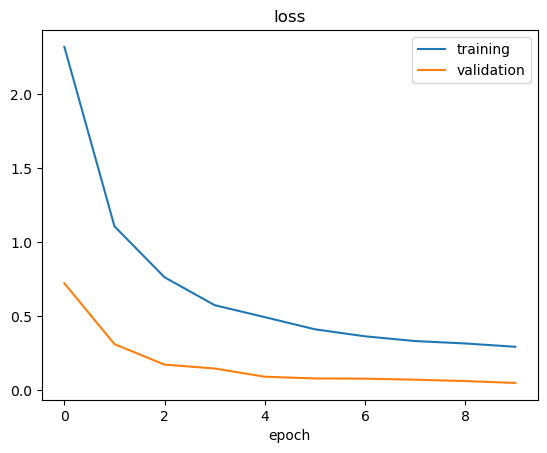

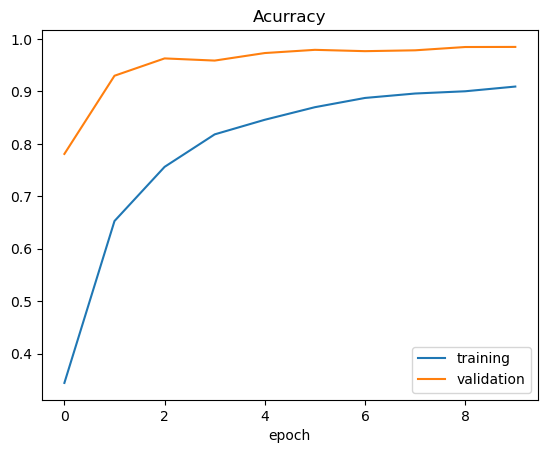

Test Score: 0.047828588634729385
Test Accuracy: 0.9850531816482544


In [12]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [13]:
# # Function to preprocess new input data
# def preprocess_new_data(img):
#     img = grayscale(img)
#     img = equalize(img)
#     img = img/255
#     # return img

In [14]:
# # Function to predict classes of new input data
# def predict_classes(img):
#     img = preprocess_new_data(img)
#     img = cv2.resize(img, (32, 32))  # Resize the image to match the input dimensions of the model
#     img = img.reshape(1, 32, 32, 1)  # Reshape the image to match the input shape of the model
#     prediction = model.predict(img)
#     predicted_class = np.argmax(prediction)
#     return predicted_class

In [15]:
# # Load your new input image
# new_input_image = cv2.imread(r"C:\Users\devan\OneDrive\Documents\Traffic Sign Recognition\images.png")
# predicted_class = predict_classes(new_input_image)
# # print("Predicted Class:", predicted_class)

In [16]:
model.save("model.h5")